Sumber Dataset: https://www.kaggle.com/code/rounakbanik/movie-recommender-systems#Content-Based-Recommender

In [1]:
# datasets
! wget https://files.grouplens.org/datasets/movielens/ml-25m.zip

--2025-05-28 04:08:17--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  17.2MB/s    in 16s     

2025-05-28 04:08:33 (15.7 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]



In [2]:
# unzip
! unzip ml-25m.zip -d /content/data/

Archive:  ml-25m.zip
   creating: /content/data/ml-25m/
  inflating: /content/data/ml-25m/tags.csv  
  inflating: /content/data/ml-25m/links.csv  
  inflating: /content/data/ml-25m/README.txt  
  inflating: /content/data/ml-25m/ratings.csv  
  inflating: /content/data/ml-25m/genome-tags.csv  
  inflating: /content/data/ml-25m/genome-scores.csv  
  inflating: /content/data/ml-25m/movies.csv  


## Import Library

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data

In [4]:
# membaca dataset dan menyimpannya ke dalam variabel
movies = pd.read_csv('/content/data/ml-25m/movies.csv')         # dataset film
ratings = pd.read_csv('/content/data/ml-25m/ratings.csv')       # dataset rating film
tags = pd.read_csv('/content/data/ml-25m/tags.csv')             # dataset tag film
links = pd.read_csv('/content/data/ml-25m/links.csv')           # dataset link film
genome_tags = pd.read_csv('/content/data/ml-25m/genome-tags.csv')   # dataset tag genome film
genome_scores = pd.read_csv('/content/data/ml-25m/genome-scores.csv') # dataset skor relevansi tag

# menampilkan jumlah nilai unik dari masing-masing dataframe
print('Total film yang tersedia: ', len(movies.movieId.unique()))
print('Total pengguna yang memberikan rating: ', len(ratings.userId.unique()))
print('Total pengguna yang memberikan tag: ', len(tags.userId.unique()))
print('Total film yang memiliki link referensi: ', len(links.movieId.unique()))
print('Total tag unik pada genome tags: ', len(genome_tags.tagId.unique()))
print('Total film yang memiliki skor genome: ', len(genome_scores.movieId.unique()))


Total film yang tersedia:  62423
Total pengguna yang memberikan rating:  162541
Total pengguna yang memberikan tag:  14592
Total film yang memiliki link referensi:  62423
Total tag unik pada genome tags:  1128
Total film yang memiliki skor genome:  13816


Membaca file CSV dataset ke DataFrame pandas untuk data film, rating, tag, link, genome tags dan scores. Dataset ini terdiri dari banyak file yang saling melengkapi untuk analisis rekomendasi.

## Data Inspection & Cleaning

Menampilkan info kolom, tipe data, dan nilai non-null untuk memastikan data lengkap dan mengetahui tipe data yang akan diproses.

In [5]:
# informasi dataset movies
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [6]:
# informasi dataset ratings
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [7]:
# informasi dataset tags
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


In [8]:
# informasi dataset links
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


In [9]:
# informasi dataset genome_tags
genome_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


In [10]:
# informasi dataset genome_scores
genome_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


Menggabungkan dan menghapus duplikasi tagId, movieId, dan userId dari dataset yang berbeda untuk mendapatkan total keseluruhan unik. Memastikan semua data konsisten dan lengkap.

In [11]:
# Mengambil semua tagId unik dari kedua dataset genome_tags dan genome_scores, lalu digabungkan
genome_tags_all = np.concatenate((genome_tags.tagId.unique(), genome_scores.tagId.unique()))

# Menghapus duplikasi dan mengurutkan tagId hasil gabungan
genome_tags_all = np.sort(np.unique(genome_tags_all))

# Menampilkan jumlah total tagId unik setelah digabung dan disortir
print('Jumlah seluruh data genome_tags: ', len(genome_tags_all))

Jumlah seluruh data genome_tags:  1128


In [12]:
# Mengambil semua movieId unik dari keempat dataset: movies, tags, ratings, dan links, lalu digabungkan
movies_all = np.concatenate((
    movies.movieId.unique(),
    tags.movieId.unique(),
    ratings.movieId.unique(),
    links.movieId.unique()
))

# Menghapus duplikasi movieId dan mengurutkan hasilnya
movies_all = np.sort(np.unique(movies_all))

# Menampilkan jumlah total movieId unik setelah digabung dan disortir
print('Jumlah seluruh data movies berdasarkan movieId: ', len(movies_all))

Jumlah seluruh data movies berdasarkan movieId:  62423


In [13]:
# Mengambil semua userId unik dari dataset ratings dan tags, lalu digabungkan
user_all = np.concatenate((
    ratings.userId.unique(),
    tags.userId.unique()
))

# Menghapus duplikasi userId dan mengurutkan hasil gabungan
user_all = np.sort(np.unique(user_all))

# Menampilkan jumlah total userId unik setelah digabung dan disortir
print('Jumlah seluruh data user berdasarkan userId: ', len(user_all))

Jumlah seluruh data user berdasarkan userId:  162541


In [14]:
# dataset movies
movies

movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
62418   209157                           We (2018)   
62419   209159           Window of the Soul (2001)   
62420   209163                    Bad Poems (2018)   
62421   209169                 A Girl Thing (2001)   
62422   209171      Women of Devil's Island (1962)   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  
...                                            ...  
62418                                        Drama  
62419                                  Documentary  
62420                                 Comedy|Drama  
62421                           (no genres listed)  
62422                       Action|Adventure|Drama  

[62423 rows x 3 columns]

* Mengambil tahun rilis film dari judul (biasanya di akhir dalam tanda kurung).

- Menghapus tahun dari judul agar fokus pada nama film saja saat analisis teks/genre.

- Membersihkan data untuk fitur yang lebih baik.

In [15]:
# Mengekstrak tahun rilis dari kolom title dan menyimpannya ke kolom baru 'year_of_release'
movies['year_of_release'] = movies.title.str.extract('([0-9]{4})')
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres year_of_release  
0  Adventure|Animation|Children|Comedy|Fantasy            1995  
1                   Adventure|Children|Fantasy            1995  
2                               Comedy|Romance            1995  
3                         Comedy|Drama|Romance            1995  
4                                       Comedy            1995

In [16]:
# Mengubah tipe data kolom 'title' menjadi string
movies['title'] = movies['title'].astype(str)

# Menghapus informasi tahun (atau teks setelah tanda kurung buka) dari judul film
movies['title'] = movies['title'].str.split('(', n=1).str[0].str.strip()

movies.head()

movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                        genres year_of_release  
0  Adventure|Animation|Children|Comedy|Fantasy            1995  
1                   Adventure|Children|Fantasy            1995  
2                               Comedy|Romance            1995  
3                         Comedy|Drama|Romance            1995  
4                                       Comedy            1995

In [17]:
ratings

userId  movieId  rating   timestamp
0              1      296     5.0  1147880044
1              1      306     3.5  1147868817
2              1      307     5.0  1147868828
3              1      665     5.0  1147878820
4              1      899     3.5  1147868510
...          ...      ...     ...         ...
25000090  162541    50872     4.5  1240953372
25000091  162541    55768     2.5  1240951998
25000092  162541    56176     2.0  1240950697
25000093  162541    58559     4.0  1240953434
25000094  162541    63876     5.0  1240952515

[25000095 rows x 4 columns]

In [18]:
ratings.rating.unique()

array([5. , 3.5, 4. , 2.5, 4.5, 3. , 0.5, 2. , 1. , 1.5])

Membulatkan nilai rating ke atas agar rating menjadi integer (1-5). Kemudian mengonversi kolom timestamp ke format datetime agar lebih mudah dianalisis.

In [19]:
# Membulatkan nilai pada kolom 'rating' ke atas (ceil)
ratings['rating'] = ratings['rating'].apply(np.ceil)

In [20]:
# Memeriksa kembali nilai-nilai unik yang ada di kolom 'rating'
ratings.rating.unique()

array([5., 4., 3., 1., 2.])

In [21]:
ratings.timestamp = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.head()

userId  movieId  rating           timestamp
0       1      296     5.0 2006-05-17 15:34:04
1       1      306     4.0 2006-05-17 12:26:57
2       1      307     5.0 2006-05-17 12:27:08
3       1      665     5.0 2006-05-17 15:13:40
4       1      899     4.0 2006-05-17 12:21:50

Menggabungkan data film dengan rating berdasarkan movieId. Menghapus nilai missing agar data bersih untuk pemodelan.

In [22]:
# Menggabungkan dataframe movies dan ratings berdasarkan kolom 'movieId' dengan metode left join
films = pd.merge(movies, ratings, on='movieId', how='left')

# Menampilkan dataframe hasil penggabungan
films

movieId                    title  \
0               1                Toy Story   
1               1                Toy Story   
2               1                Toy Story   
3               1                Toy Story   
4               1                Toy Story   
...           ...                      ...   
25003466   209157                       We   
25003467   209159       Window of the Soul   
25003468   209163                Bad Poems   
25003469   209169             A Girl Thing   
25003470   209171  Women of Devil's Island   

                                               genres year_of_release  \
0         Adventure|Animation|Children|Comedy|Fantasy            1995   
1         Adventure|Animation|Children|Comedy|Fantasy            1995   
2         Adventure|Animation|Children|Comedy|Fantasy            1995   
3         Adventure|Animation|Children|Comedy|Fantasy            1995   
4         Adventure|Animation|Children|Comedy|Fantasy            1995   
...                                               ...             ...   
25003466                                        Drama            2018   
25003467                                  Documentary            2001   
25003468                                 Comedy|Drama            2018   
25003469                           (no genres listed)            2001   
25003470                       Action|Adventure|Drama            1962   

            userId  rating           timestamp  
0              2.0     4.0 2006-03-03 19:57:00  
1              3.0     4.0 2015-08-13 13:23:35  
2              4.0     3.0 2019-11-16 22:44:12  
3              5.0     4.0 1997-03-17 19:12:29  
4              8.0     4.0 1998-03-21 15:01:57  
...            ...     ...                 ...  
25003466  119571.0     2.0 2019-11-20 20:12:28  
25003467  115835.0     3.0 2019-11-20 20:16:25  
25003468    6964.0     5.0 2019-11-20 21:21:53  
25003469  119571.0     3.0 2019-11-20 23:17:06  
25003470  119571.0     3.0 2019-11-20 23:18:57  

[25003471 rows x 7 columns]

In [23]:
# check missing values
(films.isnull() | films.empty | films.isna()).sum()

movieId                0
title                  0
genres                 0
year_of_release    11581
userId              3376
rating              3376
timestamp           3376
dtype: int64

In [24]:
# drop missing value
films = films.dropna()
films

movieId                    title  \
0               1                Toy Story   
1               1                Toy Story   
2               1                Toy Story   
3               1                Toy Story   
4               1                Toy Story   
...           ...                      ...   
25003466   209157                       We   
25003467   209159       Window of the Soul   
25003468   209163                Bad Poems   
25003469   209169             A Girl Thing   
25003470   209171  Women of Devil's Island   

                                               genres year_of_release  \
0         Adventure|Animation|Children|Comedy|Fantasy            1995   
1         Adventure|Animation|Children|Comedy|Fantasy            1995   
2         Adventure|Animation|Children|Comedy|Fantasy            1995   
3         Adventure|Animation|Children|Comedy|Fantasy            1995   
4         Adventure|Animation|Children|Comedy|Fantasy            1995   
...                                               ...             ...   
25003466                                        Drama            2018   
25003467                                  Documentary            2001   
25003468                                 Comedy|Drama            2018   
25003469                           (no genres listed)            2001   
25003470                       Action|Adventure|Drama            1962   

            userId  rating           timestamp  
0              2.0     4.0 2006-03-03 19:57:00  
1              3.0     4.0 2015-08-13 13:23:35  
2              4.0     3.0 2019-11-16 22:44:12  
3              5.0     4.0 1997-03-17 19:12:29  
4              8.0     4.0 1998-03-21 15:01:57  
...            ...     ...                 ...  
25003466  119571.0     2.0 2019-11-20 20:12:28  
25003467  115835.0     3.0 2019-11-20 20:16:25  
25003468    6964.0     5.0 2019-11-20 21:21:53  
25003469  119571.0     3.0 2019-11-20 23:17:06  
25003470  119571.0     3.0 2019-11-20 23:18:57  

[24988552 rows x 7 columns]

In [25]:
# check ulang missing values
(films.isnull() | films.empty | films.isna()).sum()

movieId            0
title              0
genres             0
year_of_release    0
userId             0
rating             0
timestamp          0
dtype: int64

## Exploratory Data Analysis (EDA)

Melihat berapa genre unik dan jenis-jenis genre film yang tersedia. Menghapus film yang tidak memiliki genre.

In [26]:
# Set opsi cetak NumPy agar seluruh elemen array ditampilkan tanpa dipersingkat
np.set_printoptions(threshold=sys.maxsize)

# Cetak jumlah genre unik yang ada di kolom 'genres' pada dataframe films
print('Banyak genre films: ', len(films['genres'].unique()))

# Cetak daftar lengkap genre unik pada kolom 'genres'
print('Genre films: ', films['genres'].unique())

# Kembalikan opsi cetak NumPy ke pengaturan default yang mempersingkat output panjang
np.set_printoptions(threshold=None)

Banyak genre films:  1621
Genre films:  ['Adventure|Animation|Children|Comedy|Fantasy'
 'Adventure|Children|Fantasy' 'Comedy|Romance' 'Comedy|Drama|Romance'
 'Comedy' 'Action|Crime|Thriller' 'Adventure|Children' 'Action'
 'Action|Adventure|Thriller' 'Comedy|Horror'
 'Adventure|Animation|Children' 'Drama' 'Action|Adventure|Romance'
 'Crime|Drama' 'Drama|Romance' 'Action|Comedy|Crime|Drama|Thriller'
 'Comedy|Crime|Thriller' 'Crime|Drama|Horror|Mystery|Thriller'
 'Drama|Sci-Fi' 'Children|Drama' 'Adventure|Drama|Fantasy|Mystery|Sci-Fi'
 'Mystery|Sci-Fi|Thriller' 'Adventure|Romance|IMAX' 'Documentary|IMAX'
 'Children|Comedy' 'Drama|War' 'Action|Crime|Drama'
 'Action|Adventure|Fantasy' 'Comedy|Drama|Thriller' 'Mystery|Thriller'
 'Animation|Children|Drama|Musical|Romance' 'Crime|Mystery|Thriller'
 'Action|Drama|Thriller' 'Adventure|Drama'
 'Adventure|Children|Comedy|Fantasy' 'Drama|Mystery' 'Drama|Thriller'
 'Comedy|Crime' 'Action|Sci-Fi|Thriller' 'Action|Comedy|Horror|Thriller'
 'Comedy|Dram

In [27]:
# show non-genre
films[films['genres']=='(no genres listed)']

movieId                   title              genres year_of_release  \
22550152    83773         Away with Words  (no genres listed)            1999   
22550153    83773         Away with Words  (no genres listed)            1999   
22575388    84768              Glitterbug  (no genres listed)            1994   
22575389    84768              Glitterbug  (no genres listed)            1994   
22575390    84768              Glitterbug  (no genres listed)            1994   
...           ...                     ...                 ...             ...   
25003446   209103  Tsar Ivan the Terrible  (no genres listed)            1991   
25003452   209133  The Riot and the Dance  (no genres listed)            2018   
25003453   209133  The Riot and the Dance  (no genres listed)            2018   
25003463   209151         Mao Zedong 1949  (no genres listed)            1949   
25003469   209169            A Girl Thing  (no genres listed)            2001   

            userId  rating           timestamp  
22550152   26031.0     3.0 2011-03-02 20:56:26  
22550153   72315.0     1.0 2016-04-26 19:13:25  
22575388   72315.0     3.0 2015-12-15 08:07:44  
22575389  119765.0     3.0 2011-02-28 06:24:03  
22575390  137293.0     3.0 2011-02-28 13:20:48  
...            ...     ...                 ...  
25003446   13737.0     4.0 2019-11-18 21:23:59  
25003452  127710.0     5.0 2019-11-19 17:57:15  
25003453  145795.0     1.0 2019-11-20 04:49:32  
25003463  125475.0     4.0 2019-11-20 06:44:08  
25003469  119571.0     3.0 2019-11-20 23:17:06  

[23726 rows x 7 columns]

In [28]:
films = films.loc[films.genres != '(no genres listed)']
films.head()

movieId      title                                       genres  \
0        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy   

  year_of_release  userId  rating           timestamp  
0            1995     2.0     4.0 2006-03-03 19:57:00  
1            1995     3.0     4.0 2015-08-13 13:23:35  
2            1995     4.0     3.0 2019-11-16 22:44:12  
3            1995     5.0     4.0 1997-03-17 19:12:29  
4            1995     8.0     4.0 1998-03-21 15:01:57

In [29]:
films.groupby('movieId').sum(numeric_only=True)

userId    rating
movieId                        
1        4.658910e+09  229678.0
2        1.971155e+09   81831.0
3        9.601810e+08   37885.0
4        2.050346e+08    7302.0
5        9.488676e+08   36682.0
...               ...       ...
209155   1.349160e+05       5.0
209157   1.195710e+05       2.0
209159   1.158350e+05       3.0
209163   6.964000e+03       5.0
209171   1.195710e+05       3.0

[54352 rows x 2 columns]

Memilih film yang memiliki setidaknya 50 rating agar model fokus pada data yang cukup banyak. Menghapus duplikasi berdasarkan filmId dan judul. Membersihkan genre "Sci-Fi" agar konsisten penulisannya.



In [30]:
# Menghitung frekuensi kemunculan setiap movieId di dataframe films
get_values = films['movieId'].value_counts()

# Memilih movieId yang muncul setidaknya 50 kali
temp = get_values[get_values >= 50].index

# Memfilter dataframe films agar hanya menyimpan baris dengan movieId yang frekuensinya >= 50
films = films[films['movieId'].isin(temp)]

# Menampilkan dataframe hasil filter
films

movieId                  title  \
0               1              Toy Story   
1               1              Toy Story   
2               1              Toy Story   
3               1              Toy Story   
4               1              Toy Story   
...           ...                    ...   
25002983   207830  Terminator: Dark Fate   
25002984   207830  Terminator: Dark Fate   
25002985   207830  Terminator: Dark Fate   
25002986   207830  Terminator: Dark Fate   
25002987   207830  Terminator: Dark Fate   

                                               genres year_of_release  \
0         Adventure|Animation|Children|Comedy|Fantasy            1995   
1         Adventure|Animation|Children|Comedy|Fantasy            1995   
2         Adventure|Animation|Children|Comedy|Fantasy            1995   
3         Adventure|Animation|Children|Comedy|Fantasy            1995   
4         Adventure|Animation|Children|Comedy|Fantasy            1995   
...                                               ...             ...   
25002983                                Action|Sci-Fi            2019   
25002984                                Action|Sci-Fi            2019   
25002985                                Action|Sci-Fi            2019   
25002986                                Action|Sci-Fi            2019   
25002987                                Action|Sci-Fi            2019   

            userId  rating           timestamp  
0              2.0     4.0 2006-03-03 19:57:00  
1              3.0     4.0 2015-08-13 13:23:35  
2              4.0     3.0 2019-11-16 22:44:12  
3              5.0     4.0 1997-03-17 19:12:29  
4              8.0     4.0 1998-03-21 15:01:57  
...            ...     ...                 ...  
25002983  144301.0     4.0 2019-11-05 20:10:55  
25002984  148647.0     3.0 2019-11-05 03:28:35  
25002985  154088.0     4.0 2019-11-06 06:18:53  
25002986  154546.0     4.0 2019-11-02 14:07:44  
25002987  158109.0     4.0 2019-11-15 20:37:26  

[24625226 rows x 7 columns]

In [31]:
# duplicated by movieId
films.duplicated('movieId').sum()

np.int64(24612098)

In [32]:
# duplicated by title
films.duplicated('title').sum()

np.int64(24612618)

In [33]:
# drop duplicated data by movieId & title
films = films.drop_duplicates('movieId')
films = films.drop_duplicates('title')

In [34]:
# Ganti string yang cocok dengan pola regex '[nS]ci-Fi' menjadi 'Scifi' di kolom 'genres'
films['genres'] = films['genres'].str.replace('[nS]ci-Fi', 'Scifi', regex=True)

films.head()

movieId                        title  \
0            1                    Toy Story   
57309        2                      Jumanji   
81537        3             Grumpier Old Men   
93341        4            Waiting to Exhale   
95864        5  Father of the Bride Part II   

                                            genres year_of_release  userId  \
0      Adventure|Animation|Children|Comedy|Fantasy            1995     2.0   
57309                   Adventure|Children|Fantasy            1995     9.0   
81537                               Comedy|Romance            1995     8.0   
93341                         Comedy|Drama|Romance            1995   141.0   
95864                                       Comedy            1995    18.0   

       rating           timestamp  
0         4.0 2006-03-03 19:57:00  
57309     5.0 1997-03-26 13:32:22  
81537     4.0 1998-03-21 15:08:26  
93341     3.0 1996-07-30 07:29:46  
95864     4.0 2005-02-13 05:52:25

## Feature Engineering (TF-IDF Vectorizer & Cosine Similarity)

In [35]:
# Membuat salinan dataframe films ke variabel preparation
preparation = films
preparation.sort_values(by='movieId').head()

movieId                        title  \
0            1                    Toy Story   
57309        2                      Jumanji   
81537        3             Grumpier Old Men   
93341        4            Waiting to Exhale   
95864        5  Father of the Bride Part II   

                                            genres year_of_release  userId  \
0      Adventure|Animation|Children|Comedy|Fantasy            1995     2.0   
57309                   Adventure|Children|Fantasy            1995     9.0   
81537                               Comedy|Romance            1995     8.0   
93341                         Comedy|Drama|Romance            1995   141.0   
95864                                       Comedy            1995    18.0   

       rating           timestamp  
0         4.0 2006-03-03 19:57:00  
57309     5.0 1997-03-26 13:32:22  
81537     4.0 1998-03-21 15:08:26  
93341     3.0 1996-07-30 07:29:46  
95864     4.0 2005-02-13 05:52:25

In [36]:
# Mengubah kolom 'movieId' pada dataframe preparation menjadi list
film_id = preparation['movieId'].to_list()

# Mengubah kolom 'title' pada dataframe preparation menjadi list
film_name = preparation['title'].to_list()

# Mengubah kolom 'genres' pada dataframe preparation menjadi list
film_genre = preparation['genres'].to_list()

# Menampilkan panjang masing-masing list
print(len(film_id))
print(len(film_name))
print(len(film_genre))

12608
12608
12608


In [37]:
# Membuat dataframe dari dictionary yang berisi list film_id, film_name, dan film_genre
df_film = pd.DataFrame(data={
    'film_id': film_id,
    'film_name': film_name,
    'genre': film_genre
})
df_film

film_id                        film_name  \
0            1                        Toy Story   
1            2                          Jumanji   
2            3                 Grumpier Old Men   
3            4                Waiting to Exhale   
4            5      Father of the Bride Part II   
...        ...                              ...   
12603   205076                    Downton Abbey   
12604   205383  El Camino: A Breaking Bad Movie   
12605   205425  Dave Chappelle: Sticks & Stones   
12606   206499     Between Two Ferns: The Movie   
12607   207830            Terminator: Dark Fate   

                                             genre  
0      Adventure|Animation|Children|Comedy|Fantasy  
1                       Adventure|Children|Fantasy  
2                                   Comedy|Romance  
3                             Comedy|Drama|Romance  
4                                           Comedy  
...                                            ...  
12603                                        Drama  
12604                         Crime|Drama|Thriller  
12605                                       Comedy  
12606                                       Comedy  
12607                                 Action|Scifi  

[12608 rows x 3 columns]

In [38]:
# data sample
data = df_film
data.head()

film_id                    film_name  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                         genre  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

## Content-based Filtering

Menggunakan TF-IDF untuk mengubah kolom genre menjadi representasi numerik (vektor) yang menunjukkan bobot penting genre untuk setiap film. Digunakan untuk mengukur kesamaan antar film berdasarkan genre.

In [39]:
# Membuat objek TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Melatih model TF-IDF pada kolom 'genre' dari dataframe data
tfidf_vectorizer.fit(data['genre'])

# Mendapatkan daftar fitur (kata) yang dihasilkan oleh TfidfVectorizer
tfidf_vectorizer.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'film', 'horror', 'imax',
       'musical', 'mystery', 'noir', 'romance', 'scifi', 'thriller',
       'war', 'western'], dtype=object)

In [40]:
# fit & transform to matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(data['genre'])

# show matrix dimension
tfidf_matrix.shape

(12608, 20)

In [41]:
# Mengubah vektor tf-idf menjadi bentuk matriks padat (dense matrix)
tfidf_matrix.todense()

matrix([[0.        , 0.42081801, 0.51597569, 0.498606  , 0.2668904 ,
         0.        , 0.        , 0.        , 0.48666504, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.51699784, 0.        , 0.61256461, 0.        ,
         0.        , 0.        , 0.        , 0.5978945 , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.58159191,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.8134807 , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.52078435,
         0.        , 0.        , 0.44516945, 0.        , 0.        ,
         0.        , 0.        

In [42]:
# Membuat dataframe dari matriks tf-idf dengan baris sebagai film_name dan kolom sebagai genre
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf_vectorizer.get_feature_names_out(),
    index=data.film_name
).sample(n=20, axis=1).sample(n=10, axis=0)

adventure  film   romance  \
film_name                                                                     
Calibre                                            0.000000   0.0  0.000000   
Melvin Goes to Dinner                              0.000000   0.0  0.000000   
DuckTales: The Movie - Treasure of the Lost Lamp   0.420818   0.0  0.000000   
Super 8                                            0.000000   0.0  0.000000   
Skyline                                            0.000000   0.0  0.000000   
Phish: Bittersweet Motel                           0.000000   0.0  0.000000   
Shooting Fish                                      0.000000   0.0  0.813481   
Grand Day Out with Wallace and Gromit, A           0.428009   0.0  0.000000   
Sunchaser, The                                     0.000000   0.0  0.000000   
Sorority Row                                       0.000000   0.0  0.000000   

                                                  war  animation      imax  \
film_name                                                                    
Calibre                                           0.0   0.000000  0.000000   
Melvin Goes to Dinner                             0.0   0.000000  0.000000   
DuckTales: The Movie - Treasure of the Lost Lamp  0.0   0.515976  0.000000   
Super 8                                           0.0   0.000000  0.681221   
Skyline                                           0.0   0.000000  0.000000   
Phish: Bittersweet Motel                          0.0   0.000000  0.000000   
Shooting Fish                                     0.0   0.000000  0.000000   
Grand Day Out with Wallace and Gromit, A          0.0   0.524793  0.000000   
Sunchaser, The                                    0.0   0.000000  0.000000   
Sorority Row                                      0.0   0.000000  0.000000   

                                                  children     drama  \
film_name                                                              
Calibre                                           0.000000  0.000000   
Melvin Goes to Dinner                             0.000000  0.649767   
DuckTales: The Movie - Treasure of the Lost Lamp  0.498606  0.000000   
Super 8                                           0.000000  0.000000   
Skyline                                           0.000000  0.000000   
Phish: Bittersweet Motel                          0.000000  0.000000   
Shooting Fish                                     0.000000  0.000000   
Grand Day Out with Wallace and Gromit, A          0.507126  0.000000   
Sunchaser, The                                    0.000000  1.000000   
Sorority Row                                      0.000000  0.000000   

                                                    comedy  action  crime  \
film_name                                                                   
Calibre                                           0.000000     0.0    0.0   
Melvin Goes to Dinner                             0.760134     0.0    0.0   
DuckTales: The Movie - Treasure of the Lost Lamp  0.266890     0.0    0.0   
Super 8                                           0.000000     0.0    0.0   
Skyline                                           0.000000     0.0    0.0   
Phish: Bittersweet Motel                          0.000000     0.0    0.0   
Shooting Fish                                     0.581592     0.0    0.0   
Grand Day Out with Wallace and Gromit, A          0.271451     0.0    0.0   
Sunchaser, The                                    0.000000     0.0    0.0   
Sorority Row                                      0.000000     0.0    0.0   

                                                    horror  western  thriller  \
film_name                                                                       
Calibre                                           0.000000      0.0  1.000000   
Melvin Goes to Dinner                             0.000000      0.0  0.000000   
DuckTales: The Movie - Treasure of the Lost Lamp  

In [43]:
print(tfidf_matrix.shape)
print(type(tfidf_matrix))

(12608, 20)
<class 'scipy.sparse._csr.csr_matrix'>


*Dislaimer: dikarenakan keterbatasan RAM Google Collab yang saya miliki, maka dari itu untuk pengambilan subset data yang dihitung akan dibatasi*

In [44]:
# total data
n = tfidf_matrix.shape[0]

# ambil 10000 indeks acak tanpa pengulangan
random_indices = np.random.choice(n, size=10000, replace=False)

# ambil subset sparse matrix berdasarkan indeks acak
subset_matrix = tfidf_matrix[random_indices]

# hitung cosine similarity pada subset acak ini
cosine_sim_subset = cosine_similarity(subset_matrix)

# contoh: film nama yang diambil sesuai index acak
subset_film_names = data.film_name.iloc[random_indices].tolist()

In [45]:
cosine_sim_df = pd.DataFrame(
    cosine_sim_subset,
    index=subset_film_names,
    columns=subset_film_names
)
print('Shape:', cosine_sim_df.shape)
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (10000, 10000)


Thin Blue Line, The  \
Mississippi Burning                                0.000000   
Welcome to Leith                                   0.829627   
The Hunting Ground                                 1.000000   
Bridge at Remagen, The                             0.000000   
Starman                                            0.000000   
Cries and Whispers                                 0.000000   
Toys                                               0.000000   
Money                                              0.000000   
Oleanna                                            0.000000   
Where in the World Is Osama Bin Laden?             1.000000   

                                        Sweet Sweetback's Baadasssss Song  \
Mississippi Burning                                              1.000000   
Welcome to Leith                                                 0.332267   
The Hunting Ground                                               0.000000   
Bridge at Remagen, The                                           0.000000   
Starman                                                          0.117675   
Cries and Whispers                                               0.390109   
Toys                                                             0.000000   
Money                                                            0.803637   
Oleanna                                                          0.390109   
Where in the World Is Osama Bin Laden?                           0.000000   

                                        Thomas Crown Affair, The  \
Mississippi Burning                                     0.000000   
Welcome to Leith                                        0.000000   
The Hunting Ground                                      0.000000   
Bridge at Remagen, The                                  0.334752   
Starman                                                 0.000000   
Cries and Whispers                                      0.000000   
Toys                                                    0.000000   
Money                                                   0.000000   
Oleanna                                                 0.000000   
Where in the World Is Osama Bin Laden?                  0.000000   

                                        Death of a President  \
Mississippi Burning                                 0.760633   
Welcome to Leith                                    0.252733   
The Hunting Ground                                  0.000000   
Bridge at Remagen, The                              0.000000   
Starman                                             0.089507   
Cries and Whispers                                  0.296730   
Toys                                                0.000000   
Money                                               0.611273   
Oleanna                                             0.296730   
Where in the World Is Osama Bin Laden?              0.000000   

                                        Samurai I: Musashi Miyamoto  
Mississippi Burning                                        0.146895  
Welcome to Leith                                           0.000000  
The Hunting Ground                                         0.000000  
Bridge at Remagen, The                                     0.343745  
Starman                                                    0.500046  
Cries and Whispers                                         0.376549  
Toys                                                       0.000000  
Money                                                      0.182788  
Oleanna                                                    0.376549  
Where in the World Is Osama Bin Laden?                     0.000000

Fungsi yang mengambil nama film dan memberikan rekomendasi film serupa berdasarkan similarity matrix. Mengambil film dengan skor kemiripan tertinggi.

In [46]:
# function recommendations
def film_recommendations(film_name, similarity_data=cosine_sim_df, items=data[['film_name', 'genre']], k=5):
    # urutkan skor kemiripan dari tinggi ke rendah (tanpa film itu sendiri)
    similarity_scores = similarity_data[film_name].sort_values(ascending=False)

    # ambil top-k+1 teratas karena termasuk film itu sendiri
    closest = similarity_scores.iloc[1:k+1].index

    # gabungkan dengan data film untuk mendapatkan genre
    return pd.DataFrame(closest, columns=['film_name']).merge(items).head(k)

In [47]:
# sample data
data.sample(3)

film_id                film_name                          genre
6432     8169  *batteries not included  Children|Comedy|Fantasy|Scifi
5689     6755             Bubba Ho-tep                  Comedy|Horror
3948     4528               Off Limits            Action|Thriller|War

In [64]:
data[data.film_name.eq('The Raid 2: Berandal')]

film_id             film_name                  genre
10861   110501  The Raid 2: Berandal  Action|Crime|Thriller

In [48]:
film_recommendations('The Raid 2: Berandal')

film_name                  genre
0                  Batman  Action|Crime|Thriller
1                  Hitman  Action|Crime|Thriller
2                 Brother  Action|Crime|Thriller
3  Brawl in Cell Block 99  Action|Crime|Thriller
4              Deep Cover  Action|Crime|Thriller

In [49]:
df = preparation
df

movieId                            title  \
0               1                        Toy Story   
57309           2                          Jumanji   
81537           3                 Grumpier Old Men   
93341           4                Waiting to Exhale   
95864           5      Father of the Bride Part II   
...           ...                              ...   
25000108   205076                    Downton Abbey   
25000617   205383  El Camino: A Breaking Bad Movie   
25000936   205425  Dave Chappelle: Sticks & Stones   
25001872   206499     Between Two Ferns: The Movie   
25002933   207830            Terminator: Dark Fate   

                                               genres year_of_release  userId  \
0         Adventure|Animation|Children|Comedy|Fantasy            1995     2.0   
57309                      Adventure|Children|Fantasy            1995     9.0   
81537                                  Comedy|Romance            1995     8.0   
93341                            Comedy|Drama|Romance            1995   141.0   
95864                                          Comedy            1995    18.0   
...                                               ...             ...     ...   
25000108                                        Drama            2019  2111.0   
25000617                         Crime|Drama|Thriller            2019  1099.0   
25000936                                       Comedy            2019  2165.0   
25001872                                       Comedy            2019   847.0   
25002933                                 Action|Scifi            2019  4515.0   

          rating           timestamp  
0            4.0 2006-03-03 19:57:00  
57309        5.0 1997-03-26 13:32:22  
81537        4.0 1998-03-21 15:08:26  
93341        3.0 1996-07-30 07:29:46  
95864        4.0 2005-02-13 05:52:25  
...          ...                 ...  
25000108     5.0 2019-11-05 01:46:17  
25000617     5.0 2019-10-17 09:33:22  
25000936     2.0 2019-09-08 01:32:54  
25001872     2.0 2019-09-29 05:01:05  
25002933     4.0 2019-10-31 12:20:02  

[12608 rows x 7 columns]

## Collaborative Filtering

Mengubah ID asli user dan film menjadi angka berurutan untuk diproses dalam embedding model. Ini penting untuk input layer embedding pada neural network.

In [50]:
# ubah nilai unik dari 'userId' menjadi list
user_ids = list(set(df['userId']))
print('list userID: ', user_ids)

# encode 'userId'
user_to_user_encoded = dict(zip(user_ids, range(len(user_ids))))
print('encoded userID : ', user_to_user_encoded)

# encoding index ke 'userId'
user_encoded_to_user = dict(zip(range(len(user_ids)), user_ids))
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 8215.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 50.0, 51.0, 52.0, 53.0, 55.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 72.0, 73.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 82.0, 83.0, 84.0, 85.0, 86.0, 88.0, 91.0, 93.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 123.0, 124.0, 125.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 135.0, 137.0, 138.0, 139.0, 141.0, 142.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0, 162.0, 163.0, 164.0, 166.0, 167.0, 169.0, 171.0, 172.0, 173.0, 174.0, 175.0, 16559.0, 177.0, 178.0, 179.0, 8369

In [51]:
# ubah nilai unik dari 'movieId' menjadi list
films_ids = list(set(df['movieId']))

# encode 'movieId'
films_to_films_encoded = dict(zip(films_ids, range(len(films_ids))))

# encoding index ke 'movieId'
films_encoded_to_films = dict(zip(range(len(films_ids)), films_ids))

In [52]:
# Menambahkan kolom 'user' berdasarkan hasil encoding 'userId'
df.loc[:, 'user'] = df['userId'].apply(lambda x: user_to_user_encoded[x])

# Menambahkan kolom 'films' berdasarkan hasil encoding 'movieId'
df.loc[:, 'films'] = df['movieId'].apply(lambda x: films_to_films_encoded[x])

In [53]:
# Menghitung jumlah user unik
num_users = df['user'].nunique()
print(num_users)

# Menghitung jumlah film unik
num_films = df['films'].nunique()
print(num_films)

# Mengubah tipe data rating menjadi float32
df['rating'] = df['rating'].astype('float32')

# Mengambil nilai rating minimum dan maksimum
min_rating = df['rating'].min()
max_rating = df['rating'].max()

# Menampilkan informasi jumlah user, film, dan nilai rating
print(f'Number of User: {num_users}, Number of Films: {num_films}, Min Rating: {min_rating}, Max Rating: {max_rating}')


1411
12608
Number of User: 1411, Number of Films: 12608, Min Rating: 1.0, Max Rating: 5.0


**Split Data for Training and Validation**

melakukan sampling dan pembagian data menjadi data training dan validasi dgn proporsi 80/20

In [54]:
# sampling
df = df.sample(frac=1, random_state=42)
df

movieId                         title                        genres  \
23341424   101850        Death on the Staircase             Crime|Documentary   
8488133      1599                         Steel                        Action   
16427597     5334                  Cadillac Man                  Comedy|Crime   
21916204    71135                      Pandorum         Horror|Scifi|Thriller   
15478799     4501  Elvira, Mistress of the Dark                 Comedy|Horror   
...           ...                           ...                           ...   
24652771   165141                        Trolls  Adventure|Animation|Children   
17201274     6064         Harder They Fall, The               Drama|Film-Noir   
17365649     6337                Owning Mahowny          Crime|Drama|Thriller   
5364022       966             A Walk in the Sun                     Drama|War   
19229283    27717               Pearls and Pigs                        Comedy   

         year_of_release  userId  rating           timestamp  user  films  
23341424            2004  1401.0     5.0 2018-12-09 17:43:30   696   9967  
8488133             1997   695.0     1.0 1999-09-27 00:46:23   440   1544  
16427597            1990   132.0     4.0 2002-07-22 10:34:18   113   5101  
21916204            2009    13.0     4.0 2011-02-17 04:34:21    12  12018  
15478799            1988   261.0     5.0 2001-09-05 00:18:49   211   4306  
...                  ...     ...     ...                 ...   ...    ...  
24652771            2016  1232.0     4.0 2017-02-01 05:18:50   643   1270  
17201274            1956   653.0     3.0 2019-10-07 12:08:24   421   5773  
17365649            2003   450.0     4.0 2015-08-17 06:49:32   324   6011  
5364022             1945  2177.0     4.0 1999-06-07 16:44:00   897    937  
19229283            2003  2720.0     4.0 2009-10-04 17:02:30  1008  11495  

[12608 rows x 9 columns]

In [55]:
# Mengambil fitur user dan films
x = df[['user', 'films']].values

# Normalisasi rating ke rentang 0-1
y = df['rating'].apply(lambda r: (r - min_rating) / (max_rating - min_rating)).values

# Membagi data menjadi training dan validation dengan proporsi 80:20 secara acak
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, random_state=42, shuffle=True
)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(10086, 2) (10086,)
(2522, 2) (2522,)


### Proses Training Model

In [56]:
class RecommenderNet(tf.keras.Model):

    def __init__(self, num_users, num_films, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_films = num_films
        self.embedding_size = embedding_size

        # User embedding dan bias
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        # Film embedding dan bias
        self.films_embedding = layers.Embedding(
            input_dim=num_films,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.films_bias = layers.Embedding(num_films, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        films_vector = self.films_embedding(inputs[:, 1])
        films_bias = self.films_bias(inputs[:, 1])

        # Menghitung hasil dot product antara user dan film embedding
        dot_product = tf.reduce_sum(user_vector * films_vector, axis=1, keepdims=True)

        # Menjumlahkan dot product dengan bias user dan film
        x = dot_product + user_bias + films_bias

        return tf.nn.sigmoid(x)

Model di compile dengan menggunakan BinaryCrossentropy sebagai fungsi loss, Adam (Adaptive Moment Estimation) sebagai optimizer, serta root mean squared error (RMSE) sebagai metrik evaluasi.

In [57]:
model = RecommenderNet(num_users, num_films, 50) # model initialization

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [58]:
# training
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 25,
    validation_data = (x_val, y_val)
)

Epoch 1/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.6902 - root_mean_squared_error: 0.2947 - val_loss: 0.6803 - val_root_mean_squared_error: 0.2841
Epoch 2/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6688 - root_mean_squared_error: 0.2732 - val_loss: 0.6716 - val_root_mean_squared_error: 0.2761
Epoch 3/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6226 - root_mean_squared_error: 0.2318 - val_loss: 0.6670 - val_root_mean_squared_error: 0.2712
Epoch 4/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.5740 - root_mean_squared_error: 0.1759 - val_loss: 0.6658 - val_root_mean_squared_error: 0.2692
Epoch 5/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.5425 - root_mean_squared_error: 0.1345 - val_loss: 0.6642 - val_root_mean_squared_error: 0.2670
Epoch 6/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.5232 - root_mean_squared_error: 0.1058 - val_loss: 0.6642 - val_root_mean_squared_error: 0.2662
Epoch 7/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 10m

Memvisualisasikan perkembangan error pada data training dan validasi. Membantu melihat apakah model overfitting atau underfitting.

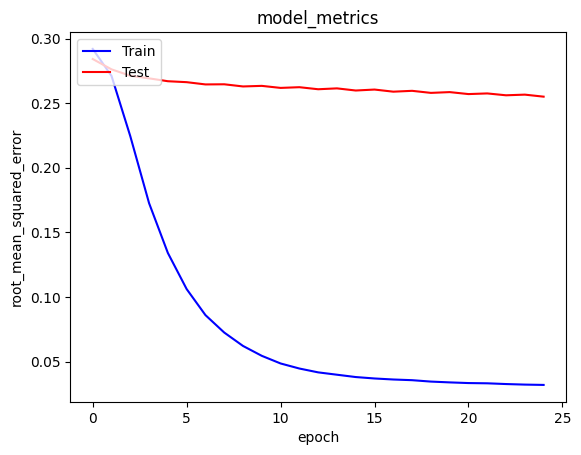

In [59]:
# plot metrics evaluations
plt.plot(history.history['root_mean_squared_error'], color='blue')
plt.plot(history.history['val_root_mean_squared_error'], color='red')
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

dari visualisasi ini, didapatkan hasil error akhir sebesar 0.03 dan error pada data validasi sebesar 0.25

In [60]:
# films
films_df = df_film
films_df.head()

film_id                    film_name  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                         genre  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [61]:
# data ratings
df = films
df.head()

movieId                        title  \
0            1                    Toy Story   
57309        2                      Jumanji   
81537        3             Grumpier Old Men   
93341        4            Waiting to Exhale   
95864        5  Father of the Bride Part II   

                                            genres year_of_release  userId  \
0      Adventure|Animation|Children|Comedy|Fantasy            1995     2.0   
57309                   Adventure|Children|Fantasy            1995     9.0   
81537                               Comedy|Romance            1995     8.0   
93341                         Comedy|Drama|Romance            1995   141.0   
95864                                       Comedy            1995    18.0   

       rating           timestamp  user  films  
0         4.0 2006-03-03 19:57:00     1      0  
57309     5.0 1997-03-26 13:32:22     8      1  
81537     4.0 1998-03-21 15:08:26     7      2  
93341     3.0 1996-07-30 07:29:46   119      3  
95864     4.0 2005-02-13 05:52:25    17      4

- Memilih pengguna acak.
- Mengambil film yang belum pernah ditonton user tersebut.
- Melakukan prediksi rating terhadap film tersebut.
- Mengambil 10 film dengan prediksi rating tertinggi sebagai rekomendasi.

In [62]:
# Mengambil satu sampel user secara acak
user_id = df['userId'].sample(n=1).iloc[0]

# Film yang sudah ditonton oleh user tersebut
films_visited_by_user = df[df['userId'] == user_id]

# Film yang belum ditonton user (menggunakan operator ~ untuk negasi)
films_not_visited = films_df.loc[
    ~films_df['film_id'].isin(films_visited_by_user['movieId'].values), 'film_id'
]

# Filter film yang ada di encoding film
films_not_visited = list(set(films_not_visited).intersection(set(films_to_films_encoded.keys())))

# Membuat list encoded film yang belum ditonton
films_not_visited = [[films_to_films_encoded[x]] for x in films_not_visited]

# Mengambil encoded user
user_encoder = user_to_user_encoded[user_id]

# Membuat array kombinasi user dengan semua film yang belum ditonton
user_films_array = np.hstack((
    np.full((len(films_not_visited), 1), user_encoder),
    films_not_visited
))

In [63]:
# Prediksi rating film yang belum ditonton user
ratings = model.predict(user_films_array).flatten()

# Ambil indeks 10 rating tertinggi secara terbalik (descending)
top_ratings_indices = np.argsort(ratings)[-10:][::-1]

# Mapping indeks ke film_id asli
recommended_films_ids = [films_encoded_to_films[films_not_visited[i][0]] for i in top_ratings_indices]

print(f"Showing recommendations for users: {user_id}")
print("===" * 9)
print("Films with high ratings from user")
print("----" * 8)

# Ambil 5 film dengan rating tertinggi yang sudah ditonton user
top_films_user = films_visited_by_user.sort_values(by='rating', ascending=False).head(5)['movieId'].values

# Tampilkan nama dan genre film yang sudah ditonton
for _, row in films_df[films_df['film_id'].isin(top_films_user)].iterrows():
    print(f"{row.film_name} : {row.genre}")

print("----" * 8)
print("Top 10 films recommendation")
print("----" * 8)

# Tampilkan rekomendasi film berdasarkan prediksi model
for _, row in films_df[films_df['film_id'].isin(recommended_films_ids)].iterrows():
    print(f"{row.film_name} : {row.genre}")


394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Showing recommendations for users: 2601.0
Films with high ratings from user
--------------------------------
Lady in a Cage : Drama|Thriller
--------------------------------
Top 10 films recommendation
--------------------------------
Drop Zone : Action|Thriller
Careful : Comedy|Horror
Big Bad Mama : Action|Comedy
Big Wednesday : Comedy|Drama
Box of Moon Light : Comedy|Drama
Night Moves : Crime|Thriller
Devil's Rejects, The : Action|Crime|Horror
Memento Mori : Horror
Babylon 5: The Legend of the Rangers: To Live and Die in Starlight : Scifi
Fail Safe : Drama|Thriller
